In [1]:
from pathlib import Path
from sqlalchemy import create_engine, text
from tqdm import tqdm
from datetime import datetime, date, timedelta
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier, plot_importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys

In [2]:
ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

pd.set_option('display.max_columns', None)

In [3]:
from config import DB_URI
from sklearn.metrics import (
    roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve

In [16]:
engine = create_engine(DB_URI)
connection = engine.connect()

In [6]:
test_query = f"""
SELECT *
FROM incidents
LIMIT 1;
"""

    identifier,
    CASE 
        WHEN business_status IS NULL THEN 0
        WHEN business_status = 'Investigation' THEN 1
        ELSE NULL
    END AS business_status_numeric,

In [49]:
query = f"""
SELECT alarm_id, created_at, probability, brand,
    CASE 
        WHEN business_status IS NULL THEN 0
        WHEN business_status = 'Investigation' THEN 1
        ELSE NULL
    END AS business_status_numeric
FROM incidents
WHERE brand = 'JET';
"""

In [50]:
df = pd.read_sql_query(text(query), connection)

print(f"Датафрейм: {df.shape[0]} строк")

Датафрейм: 4889 строк


In [9]:
df.columns

Index(['id', 'alarm_id', 'alarm_type', 'business_status',
       'business_sub_status', 'create_date_time_utc', 'operator_choice_time',
       'operator_name', 'tracker_id', 'last_order_id', 'last_order_start',
       'last_order_end', 'order_track', 'after_order_track',
       'end_order_location', 'telemetry', 'after_order_start',
       'after_order_end', 'probability', 'model_info', 'created_at',
       'identifier', 'last_order_track', 'end_order_zones',
       'end_order_zones_by_radius', 'alarm_zones_by_radius', 'alarms',
       'events', 'comments', 'status', 'data', 'technical_incident', 'city',
       'vendor_id', 'brand'],
      dtype='object')

In [15]:
connection.close()  # Закрываем сломанное соединение

connection = engine.connect()  # Открываем новое чистое соединение

In [51]:
df['brand'].unique()

array(['JET'], dtype=object)

In [52]:
df['created_at'].iloc[-1]

Timestamp('2025-05-14 11:56:57.849127')

In [53]:
df[df['brand'] == 'JET'].iloc[0]

alarm_id                     6821ec4be61713a248ac9fe5
created_at                 2025-05-12 12:40:45.157895
probability                                      79.0
brand                                             JET
business_status_numeric                             0
Name: 0, dtype: object

In [55]:
count_1 = (df["business_status_numeric"] == 1).sum()
print(f"Количество бизнес-статусов = 1: {count_1}")

total = len(df)
print(f"Общее количество строк: {total}")

percent = (count_1 / total) * 100
print(f"Процент 1: {percent:.2f}%")

Количество бизнес-статусов = 1: 496
Общее количество строк: 4889
Процент 1: 10.15%


In [56]:
num_missing = df["probability"].isna().sum()

print(f"Количество пропусков в probability: {num_missing}")

Количество пропусков в probability: 61


In [57]:
df = df.dropna(subset=["probability"]).reset_index(drop=True)

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08      4332
           1       0.11      1.00      0.19       496

    accuracy                           0.14      4828
   macro avg       0.55      0.52      0.14      4828
weighted avg       0.91      0.14      0.09      4828



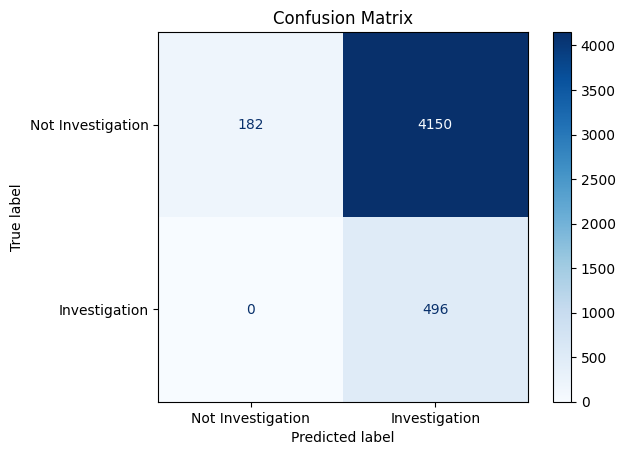

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Конвертируем вероятности в классы
y_pred_labels = (df["probability"] >= 10).astype(int)

# Оставляем только бинарные метки
y_true = df["business_status_numeric"]

print("📊 Classification Report:")
print(classification_report(y_true, y_pred_labels, zero_division=0))

cm = confusion_matrix(y_true, y_pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Investigation", "Investigation"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
